In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from copy import copy
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression, LinearRegression, PoissonRegressor
from sklearn.metrics import confusion_matrix, accuracy_score

# Statistical Learning, Lab #2: LDA, QDA, Poisson regression

## Linear Discriminant Analysis

We’ll use the Stock market data again:

In [2]:

Smarket = pd.read_csv("Smarket.csv", index_col=0)
dataf = copy(Smarket)

As we previously did with Logistic Regression in Lab1, we fit the model using only observations before 2005 (identified by the train boolean variable) with only Lag1 and Lag2 as predictors, and we want to predict the market direction for 2005.

In [3]:
predictors = dataf[["Lag1","Lag2"]]

pred_train = predictors[dataf["Year"] != np.max(dataf["Year"])]
pred_test = predictors[dataf["Year"] == np.max(dataf["Year"])]

Direction_train = dataf[dataf["Year"] != np.max(dataf["Year"])]["Direction"]
Direction_test = dataf[dataf["Year"] == np.max(dataf["Year"])]["Direction"]

We are now going to fit a LDA model using python’s LinearDiscriminantAnalysis() function, contained in the scikit-learn library.

In [4]:
lda_fit = LinearDiscriminantAnalysis()
lda_fit.fit(pred_train, Direction_train)

print("Prior probabilities of groups:")
print(pd.Series(lda_fit.priors_,index=lda_fit.classes_).to_string())

print("\nGroup means:")
print(pd.DataFrame(lda_fit.means_,index=lda_fit.classes_, columns=pred_train.columns))

print("\nCoefficients of linear discriminants:")
print(pd.DataFrame(lda_fit.scalings_,index=pred_train.columns, columns=["LDA"]))

Prior probabilities of groups:
Down    0.491984
Up      0.508016

Group means:
          Lag1      Lag2
Down  0.042790  0.033894
Up   -0.039546 -0.031325

Coefficients of linear discriminants:
           LDA
Lag1 -0.642019
Lag2 -0.513529


Note the "prior probabilities of groups", indicating that, for example, the 50.8% of training data are of days during which the market went Up.

The "Group means" tell us that the returns of the previous days tend to be positive on days when the market goes Down, and tend to be negative when the market goes Up.

The "Coefficients of linear discriminants" represent the linear combination of `Lag1` and `Lag2` used for the LDA decision rule: in our case, $-0.642 \times Lag1 - 0.514 \times Lag2$. If this quantity is large, then the LDA model will predict a market increase (`Up`), and if it is small, LDA will predict a market decline (`Down`).

After we use `predict()` and `predict.proba()` on new data, we get 2 elements:

* the predictions;
* the posterior probability of an observation belonging to the class k;



In [5]:
lda_predictions = lda_fit.predict(pred_test)
lda_probabilities = lda_fit.predict_proba(pred_test)
print(pd.Series(lda_predictions)[20:30].to_string())
print(pd.DataFrame(lda_probabilities,columns=lda_fit.classes_).loc[20:29,:])

print("\nConfusion matrix:\n", confusion_matrix(lda_predictions, Direction_test))
print("\nAccuracy:", accuracy_score(lda_predictions, Direction_test))

20    Down
21    Down
22    Down
23      Up
24    Down
25    Down
26      Up
27      Up
28      Up
29    Down
        Down        Up
20  0.500657  0.499343
21  0.510874  0.489126
22  0.503992  0.496008
23  0.491634  0.508366
24  0.504177  0.495823
25  0.502675  0.497325
26  0.491404  0.508596
27  0.480596  0.519404
28  0.488272  0.511728
29  0.506219  0.493781

Confusion matrix:
 [[ 35  35]
 [ 76 106]]

Accuracy: 0.5595238095238095


Since in the previous lab we fit a logistic regression model on the same data, we can repeat the analysis to quickly compare the performance:

In [6]:
glm_fit = LogisticRegression()
glm_fit.fit(pred_train, Direction_train)

glm_predictions = lda_fit.predict(pred_test)
glm_probabilities = lda_fit.predict_proba(pred_test)

print("\nConfusion matrix:\n", confusion_matrix(glm_predictions, Direction_test))
print("\nAccuracy:", accuracy_score(glm_predictions, Direction_test))


Confusion matrix:
 [[ 35  35]
 [ 76 106]]

Accuracy: 0.5595238095238095


The performance is identical to that of logistic regression.

Let's go back to LDA. If we threshold the posterior probabilities using the usual 0.5 threshold, we obtain the predictions reported by `lda.predict()`. 

We could also use a different threshold to make predictions: for example, 90% instead of 50%. This is easily done:

In [7]:

print(f"Down >= 0.9: {lda_probabilities[tuple([lda_probabilities[:,0] >= 0.9])].shape[0]}") #Zero!
print(f"maximum of Down: {max(lda_probabilities[:,0])}") # well, actually the max is...


Down >= 0.9: 0
maximum of Down: 0.5202349505356155


## Quadratic Discriminant Analysis

Similarly, we are now fitting a QDA model to our `Smarket` data (stored in the `df` variable). QDA is implemented in the `QuadraticDiscriminantAnalysis()` function (`scikit-learn` library), which has the same syntax as `LinearDiscriminantAnalysis()`:

In [8]:
qda_fit = QuadraticDiscriminantAnalysis()
qda_fit.fit(pred_train, Direction_train)

print("Prior probabilities of groups:")
print(pd.Series(qda_fit.priors_,index=qda_fit.classes_).to_string())

print("\nGroup means:")
print(pd.DataFrame(qda_fit.means_,index=qda_fit.classes_, columns=pred_train.columns))

print("\nCoefficients of linear discriminants:")
print(pd.DataFrame(qda_fit.scalings_,index=pred_train.columns, columns=["Linear","Quadratic"]))


Prior probabilities of groups:
Down    0.491984
Up      0.508016

Group means:
          Lag1      Lag2
Down  0.042790  0.033894
Up   -0.039546 -0.031325

Coefficients of linear discriminants:
        Linear  Quadratic
Lag1  1.562945   1.479273
Lag2  1.534551   1.472723


As usual, we fitted a QDA model on the training portion of `dataf`.

Compare the output with LDA's. What's different?

Well, the coefficients of discriminants are four now, since the QDA model involves a quadratic function of the predictors.

We can `predict()` on unseen data (`df.2005`) exactly like we are used to:

In [9]:
qda_predictions = qda_fit.predict(pred_test)
qda_probabilities = qda_fit.predict_proba(pred_test)
print(pd.Series(qda_predictions)[20:30].to_string())
print(pd.DataFrame(qda_probabilities,columns=qda_fit.classes_).loc[20:29,:])

print("\nConfusion matrix:\n", confusion_matrix(qda_predictions, Direction_test))
print("\nAccuracy:", accuracy_score(qda_predictions, Direction_test))

20      Up
21    Down
22    Down
23      Up
24    Down
25    Down
26      Up
27      Up
28      Up
29    Down
        Down        Up
20  0.497838  0.502162
21  0.508823  0.491177
22  0.501994  0.498006
23  0.489090  0.510910
24  0.501155  0.498845
25  0.502943  0.497057
26  0.488594  0.511406
27  0.477367  0.522633
28  0.487549  0.512451
29  0.503184  0.496816

Confusion matrix:
 [[ 30  20]
 [ 81 121]]

Accuracy: 0.5992063492063492



We reach an accuracy of about 60%: this is interesting, given that we didn't use the 2005 data to fit the model and that the stock market is known to be hard to model accurately.

This means that the quadratic form in the QDA model is able to model the relationship between data and outcome *more accurately than the linear forms* in LDA and logistic regression.

Before making any further inference, remember that it is better to evaluate the performance of this model on an even larger test set!

## Poisson regression

This family of generalized linear models is particularly used for modeling events where the outcomes are counts, or in general *count data* (discrete data with non-negative integer values). A typical example is the number of times an event occurs in a specific timeframe. Note that count data can also be expressed as *rates* or *frequencies*.

So far, we have been experimenting on the `Smarket` data set: let's focus now on a new data set, `Bikeshare`.

In [10]:
Bikeshare = pd.read_csv("Bikeshare.csv", index_col=0)
dataf = copy(Bikeshare)

print(dataf.columns.to_list())

['season', 'mnth', 'day', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered', 'bikers']


This data set reports the number of bike rentals per hour (`bikers`) in Washington, D.C., among with other variables such as:

* `mnth`, month of the year (factor)
* `hr`, hour of the day (factor)
* `workingday`, working day Yes/No (dummy variable with values 1/0)
* `temp`, normalized temperature in Celsius
* `weathersit`, weather condition (factor with 4 levels)

>Do you recall what a "dummy variable" is?

We will use these five variables as predictors to model the target variable `bikers`.

The number of rentals per hours can take only non-negative integer values: it is a suitable setting for applying Poisson regression.

We start by fitting a poisson regression model to the data:

In [11]:
#preprocessing of categorical predictors
categorical_columns = ["mnth","hr","weathersit"]
newdataf = pd.get_dummies(dataf, columns=categorical_columns)

predictors = newdataf.drop(['season', 'day', 'holiday', 'weekday', 'atemp','hum','windspeed',
    'casual','registered', 'bikers'],axis=1)

mod_pois = PoissonRegressor()
mod_pois.fit(predictors,dataf["bikers"])

coefficients = pd.Series(mod_pois.coef_,index=predictors.columns)
print(coefficients[:14].to_string())

workingday    0.012778
temp          0.882155
mnth_April    0.008188
mnth_Aug      0.112196
mnth_Dec      0.018168
mnth_Feb     -0.367149
mnth_Jan     -0.533695
mnth_July     0.063451
mnth_June     0.181601
mnth_March   -0.253606
mnth_May      0.206811
mnth_Nov      0.133476
mnth_Oct      0.236782
mnth_Sept     0.193744


To interpret the results, let's recall the general mathematical form of Poisson regression:

$$ log(E[y|x]) = \alpha + \sum_{i=1}^{p}\beta_i x_i $$

In the model summary, `Estimate` contains the coefficient values of $\alpha$ (the intercept), $\beta_1$, and so on.

* $exp(\alpha)$ is the effect on the mean when $x=0$;
* for $\beta=0$ the expected count is $exp(\alpha)$ (y and x are not related)
* $\beta>0$ means that the expected count is $exp(\beta)$ times *larger* than when $x=0$;
* $\beta<0$ means that the expected count is $exp(\beta)$ times *smaller* than when $x=0$.

Now we can reproduce Figure 4.15:

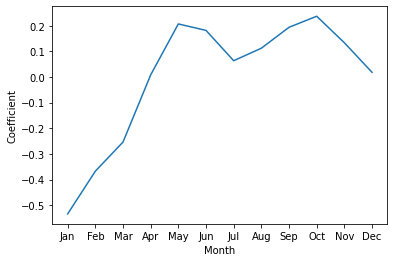

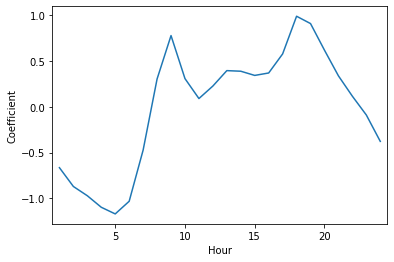

In [12]:
months = coefficients[2:14]
months = months.reindex(["mnth_Jan","mnth_Feb","mnth_March","mnth_April","mnth_May",
    "mnth_June","mnth_July","mnth_Aug","mnth_Sept","mnth_Oct","mnth_Nov","mnth_Dec"])
months.index = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
plt.plot(months)
plt.xlabel("Month")
plt.ylabel("Coefficient")
plt.show()

hours = coefficients[14:38]
hours.index = list(range(1,25))
plt.plot(hours)
plt.xlabel("Hour")
plt.ylabel("Coefficient")
plt.xlim(0.5,24.5)
plt.show()


To obtain the fitted values from this Poisson regression model, we use `predict()` to get:

$$exp(\hat{\beta_0} + \hat{\beta_1}X_1 + \ldots \hat{\beta_p}X_p)$$

And then we compare the results with the predictions of a linear model


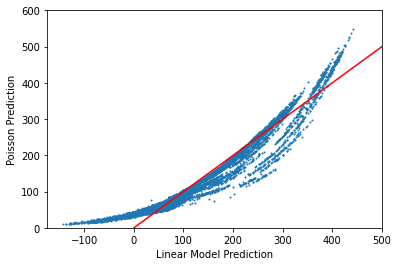

In [14]:
pois_predictions = mod_pois.predict(predictors)

mod_lm = LinearRegression()
mod_lm.fit(predictors,dataf["bikers"])

lm_predictions = mod_lm.predict(predictors)

plt.scatter(lm_predictions,pois_predictions,s=1)
plt.plot(range(0,600),range(0,600),c="r")
plt.xlabel("Linear Model Prediction")
plt.ylabel("Poisson Prediction")
plt.xlim(-175,500)
plt.ylim(0,600)
plt.show()

The predictions from the Poisson regression model tend to be larger than those from the linear model for very low or very high levels of `bikers`: this is because the Poisson predictions are non-negative.